In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

import mmh3

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import xgboost


In [2]:
df =pd.read_csv("./data/train_values.csv")
tr_labels = pd.read_csv("./data/train_labels.csv")
df = df.merge(tr_labels, how='left', on='id')

In [3]:
not_working =df[df['status_group'] != 'functional']
working = df[df['status_group'] == 'functional']

In [4]:
df =df.drop([ 'funder', 'gps_height', 'installer', 'wpt_name'
            , 'num_private', 'population', 'public_meeting', 'recorded_by', 'permit',
            'scheme_management', 'scheme_name', 'quantity_group', 'extraction_type',
            'extraction_type_group', 'source', 'payment', 'waterpoint_type' ], axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   longitude              59400 non-null  float64
 4   latitude               59400 non-null  float64
 5   basin                  59400 non-null  object 
 6   subvillage             59029 non-null  object 
 7   region                 59400 non-null  object 
 8   region_code            59400 non-null  int64  
 9   district_code          59400 non-null  int64  
 10  lga                    59400 non-null  object 
 11  ward                   59400 non-null  object 
 12  construction_year      59400 non-null  int64  
 13  extraction_type_class  59400 non-null  object 
 14  management             59400 non-null  object 
 15  ma

In [6]:
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df['year_recorded'] = df['date_recorded'].apply(lambda x: x.strftime('%Y')).astype(int)
df['date_recorded'] = df['date_recorded'].apply(lambda x: x.strftime('%Y-%m'))


In [7]:
df.year_recorded

0        2011
1        2013
2        2013
3        2013
4        2011
         ... 
59395    2013
59396    2011
59397    2011
59398    2011
59399    2011
Name: year_recorded, Length: 59400, dtype: int32

In [8]:
tr_labels['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [24]:
df_cut = df[['quantity', 'region', 'extraction_type_class', 'waterpoint_type_group', 'payment_type', 'source_type', 'status_group']]

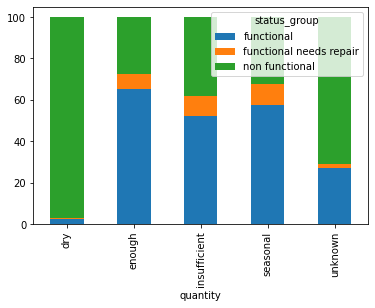

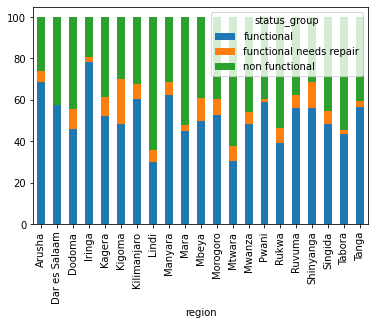

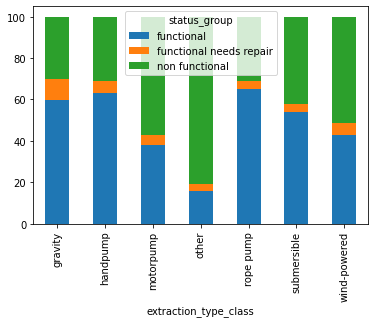

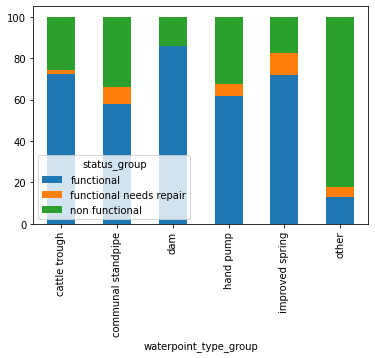

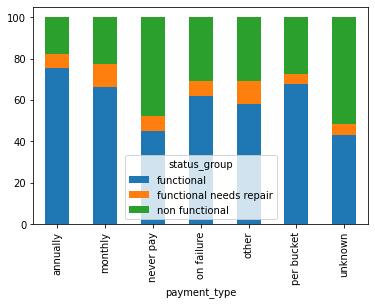

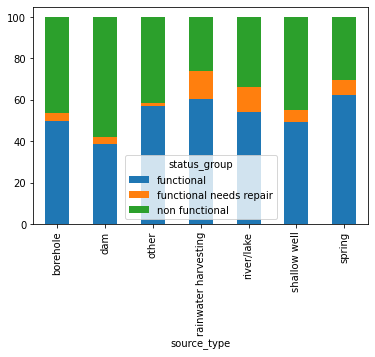

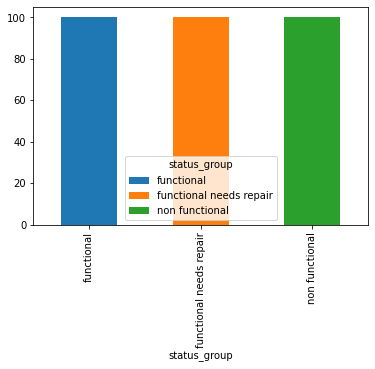

In [34]:
for column in df_cut:
    pd.crosstab(df_cut[column], df_cut['status_group']
                            ).apply(lambda x: x/x.sum()*100, axis=1
                            ).plot(kind="bar",stacked=True)

In [9]:
df.describe()

,id,amount_tsh,longitude,latitude,region_code,district_code,construction_year,year_recorded
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,34.077427,-5.706033e+00,15.297003,5.629747,1300.652475,2011.921667
std,21453.128371,2997.574558,6.567432,2.946019e+00,17.587406,9.633649,951.620547,0.958758
min,0.000000,0.000000,0.000000,-1.164944e+01,1.000000,0.000000,0.000000,2002.000000
25%,18519.750000,0.000000,33.090347,-8.540621e+00,5.000000,2.000000,0.000000,2011.000000
50%,37061.500000,0.000000,34.908743,-5.021597e+00,12.000000,3.000000,1986.000000,2012.000000
75%,55656.500000,20.000000,37.178387,-3.326156e+00,17.000000,5.000000,2004.000000,2013.000000
max,74247.000000,350000.000000,40.345193,-2.000000e-08,99.000000,80.000000,2013.000000,2013.000000


In [10]:
def cat_comb(df, category, threshold=5):
    series = pd.value_counts(df[category])
    mask = (series / series.sum() * 100).lt(threshold)
    df[category] = np.where(df[category].isin(series[mask].index),'other', df[category])
    return df[category]


In [11]:
df.basin.value_counts(normalize=True)

Lake Victoria              0.172525
Pangani                    0.150505
Rufiji                     0.134276
Internal                   0.131061
Lake Tanganyika            0.108283
Wami / Ruvu                0.100791
Lake Nyasa                 0.085606
Ruvuma / Southern Coast    0.075640
Lake Rukwa                 0.041313
Name: basin, dtype: float64

def hashit(df, column):
    return df[column].apply(lambda x: mmh3.hash(x, seed=42, signed=True)&100)

In [12]:
#df['region'] = hashit(df, 'region')
df.lga.value_counts()

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

sns.histplot(df.status_group)



fig = plt.figure(figsize=(20,15))
ax = sns.scatterplot(data=working[working['construction_year'] != 0], x='longitude', y='latitude', alpha=0.2, hue='construction_year', marker='.')
'''
ax.set(  xlabel='Budget($100 Million)',
         ylabel='Return on Investment(%)', 
         title='Returns by Budget',
         xticks=np.arange(0, 340000000, 50000000), 
         yticks=np.arange(0, 51, 10),  )
'''

plt.xlim([29,41])
plt.ylim([-12,0])
plt.show()

In [13]:
df = df.drop(['id', 'date_recorded', 'year_recorded','status_group', 'construction_year', 'management', 'latitude', 'longitude'], axis=1)

In [14]:
df_cont = df['amount_tsh']
df_cat = df.drop(['amount_tsh'], axis=1)

In [15]:
df_catstr = df_cat.drop(['region_code', 'district_code'], axis=1)

In [16]:
df_cat

,basin,subvillage,region,region_code,district_code,lga,ward,extraction_type_class,management_group,payment_type,water_quality,quality_group,quantity,source_type,source_class,waterpoint_type_group
0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,gravity,user-group,annually,soft,good,enough,spring,groundwater,communal standpipe
1,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,gravity,user-group,never pay,soft,good,insufficient,rainwater harvesting,surface,communal standpipe
2,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,gravity,user-group,per bucket,soft,good,enough,dam,surface,communal standpipe
3,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,submersible,user-group,never pay,soft,good,dry,borehole,groundwater,communal standpipe
4,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,gravity,other,never pay,soft,good,seasonal,rainwater harvesting,surface,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,gravity,user-group,per bucket,soft,good,enough,spring,groundwater,communal standpipe
59396,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,gravity,user-group,annually,soft,good,enough,river/lake,surface,communal standpipe
59397,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,handpump,user-group,monthly,fluoride,fluoride,enough,borehole,groundwater,hand pump
59398,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,handpump,user-group,never pay,soft,good,insufficient,shallow well,groundwater,hand pump


In [17]:
df_cont = pd.DataFrame(df_cont)

In [18]:
scaler = StandardScaler()

df_cont = scaler.fit_transform(df_cont)
df_cont = pd.DataFrame(df_cont)

In [19]:
for column in df_cat:
    print(column)
    print (len(df_cat[column].value_counts()))

basin
9
subvillage
19287
region
21
region_code
27
district_code
20
lga
125
ward
2092
extraction_type_class
7
management_group
5
payment_type
7
water_quality
8
quality_group
6
quantity
5
source_type
7
source_class
3
waterpoint_type_group
6


In [20]:
df_cat = df_cat.drop(['subvillage', 'ward', 'basin'], axis=1)

In [21]:
df_cat = pd.get_dummies(df_cat)


df_cat[['region', 'region_code', 'district_code']] =df_cat[['region', 'region_code', 'district_code']].astype('string')

for column in df_cat:
   df_cat[column] = hashit(df_cat, column)

In [22]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Columns: 202 entries, region_code to waterpoint_type_group_other
dtypes: int64(2), uint8(200)
memory usage: 12.7 MB


In [23]:
df = pd.concat([df_cont, df_cat], axis=1)

In [24]:
le = LabelEncoder()

tr_labels = le.fit_transform(tr_labels.status_group)


In [25]:
X = df
y = tr_labels

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11)

In [27]:
X_test.shape

(14850, 203)

In [28]:
tree = DecisionTreeClassifier(criterion='gini', 
#                            max_features='log2',
#                            min_samples_leaf=2, 
#                            max_depth=20, 
                            class_weight='balanced')
clf_dt = tree.fit(X_train, y_train)

# Test set predictions
pred = tree.predict(X_test)
# Confusion matrix and classification report

pred_tr = tree.predict(X_train)

print(confusion_matrix(y_test, pred))

print(classification_report(y_test, pred))

print("Training Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_train, pred_tr) * 100))
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, pred) * 100))


[[5273 1792  990]
 [ 172  790  119]
 [ 907  770 4037]]
              precision    recall  f1-score   support

           0       0.83      0.65      0.73      8055
           1       0.24      0.73      0.36      1081
           2       0.78      0.71      0.74      5714

    accuracy                           0.68     14850
   macro avg       0.62      0.70      0.61     14850
weighted avg       0.77      0.68      0.71     14850

Training Accuracy for Decision Tree Classifier: 74.45%
Testing Accuracy for Decision Tree Classifier: 68.01%


def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(tree)

In [29]:
tree.feature_importances_
df.columns
feature_imp = pd.DataFrame({'feature': df.columns, 'importance': tree.feature_importances_*100})
feature_imp.sort_values(by=['importance'], ascending=False).head(20)

,feature,importance
182,quantity_dry,15.312791
0,0,5.968668
152,extraction_type_class_other,5.778805
2,district_code,4.592625
149,extraction_type_class_gravity,3.751906
6,region_Iringa,3.326265
29,lga_Bariadi,3.199062
1,region_code,3.028722
193,source_type_spring,2.142573
200,waterpoint_type_group_hand pump,2.019157


,feature,importance
3,lga,12.163934
10,source_type,11.366511
6,payment_type,10.771261
2,district_code,10.177237
4,extraction_type_class,10.063785
9,quantity,9.341607
1,region_code,9.285020
0,region,8.750916
5,management_group,4.486133
12,waterpoint_type_group,3.955747


* The above is for the hash trick

In [30]:
clf = RandomForestClassifier( n_estimators=200, 
                            max_samples=0.25,
 #                           min_samples_leaf=1, 
                            max_depth=20,  
                            class_weight='balanced').fit(X_train, y_train)

pred = clf.predict(X_test)

# Test set predictions
pred_tr = clf.predict(X_train)
# Confusion matrix and classification report

print("Training Accuracy for Random Forest Classifier: {:.4}%".format(accuracy_score(y_train, pred_tr)* 100))

print("Testing Accuracy for Random Forest Classifier: {:.4}%".format(accuracy_score(y_test, pred)* 100))

print(confusion_matrix(y_test, pred))

print(classification_report(y_test, pred))

Training Accuracy for Random Forest Classifier: 75.13%
Testing Accuracy for Random Forest Classifier: 72.24%
[[6140 1241  674]
 [ 301  658  122]
 [1256  529 3929]]
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      8055
           1       0.27      0.61      0.38      1081
           2       0.83      0.69      0.75      5714

    accuracy                           0.72     14850
   macro avg       0.63      0.69      0.64     14850
weighted avg       0.77      0.72      0.74     14850



In [31]:
feature_imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_*100})
feature_imp.sort_values(by=['importance'], ascending=False).head(20)

,feature,importance
182,quantity_dry,9.756781
0,0,5.621165
2,district_code,5.058800
1,region_code,3.932901
183,quantity_enough,3.817489
152,extraction_type_class_other,3.164210
202,waterpoint_type_group_other,2.936982
184,quantity_insufficient,2.631989
149,extraction_type_class_gravity,2.538613
29,lga_Bariadi,2.138471


Based on these, let's try to see what's important.
* Quantity is very important, especially dry and enough.
* Only use 1 geographic column. Region, especially Kigoma and Iringa 
* Extraction Type: Other and Gravity
* Waterpoint Type: Other and communal standpipe
* Payment Type: Never pay, per bucket, monthly, unknown
* Source Type: Borehole, shallow well

In [ ]:
Pipeline



In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Columns: 203 entries, 0 to waterpoint_type_group_other
dtypes: float64(1), int64(2), uint8(200)
memory usage: 12.7 MB


fig = plt.figure(figsize=(20,15))
ax = sns.scatterplot(data=df, x='longitude', y='latitude', alpha=0.2, hue='region_code', marker='.')
'''
ax.set(  xlabel='Budget($100 Million)',
         ylabel='Return on Investment(%)', 
         title='Returns by Budget',
         xticks=np.arange(0, 340000000, 50000000), 
         yticks=np.arange(0, 51, 10),  )
'''

plt.xlim([29,41])
plt.ylim([-12,0])
plt.show()

missing_year = df[df['construction_year'] == 0]
has_year = df[df['construction_year']  != 0]

In [35]:
df.region_code.unique()

array([11, 20, 21, 90, 18,  4, 17, 14, 60, 10,  3, 15, 19, 16, 80,  1,  6,
        2, 12, 13,  5,  7, 99, 24,  9,  8, 40], dtype=int64)

In [36]:
df.region_code.value_counts(normalize=True)

11    0.089226
17    0.084360
12    0.078098
3     0.073721
5     0.068013
18    0.055960
19    0.051296
2     0.050909
16    0.047407
10    0.044444
4     0.042306
1     0.037054
13    0.035236
14    0.033316
20    0.033148
15    0.030438
6     0.027088
21    0.026650
80    0.020842
60    0.017256
90    0.015438
7     0.013552
99    0.007121
9     0.006566
24    0.005488
8     0.005051
40    0.000017
Name: region_code, dtype: float64

# Strategy

* Decision Tree, Bagged, RandomForest
* Model 0: Nothing encoded or changed.
* Model 1: One Hot
    * decrease cats
* Model 2: Hash
    * decrease cats
* Fix for skew